In [3]:
%cd ..

/Users/w1ufxk2/Desktop/hotel_cancellation_forecasting/src


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss

In [5]:
pdf = pd.read_csv("data/booking.csv", sep=",")
pdf.head()


,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


In [6]:
# Let's look at whether there are nulls in the dataframe
pdf.isnull().sum(axis = 0)
# There are no nulls in the dataframe

Booking_ID                  0
number of adults            0
number of children          0
number of weekend nights    0
number of week nights       0
type of meal                0
car parking space           0
room type                   0
lead time                   0
market segment type         0
repeated                    0
P-C                         0
P-not-C                     0
average price               0
special requests            0
date of reservation         0
booking status              0
dtype: int64

In [7]:
pdf.dtypes

Booking_ID                   object
number of adults              int64
number of children            int64
number of weekend nights      int64
number of week nights         int64
type of meal                 object
car parking space             int64
room type                    object
lead time                     int64
market segment type          object
repeated                      int64
P-C                           int64
P-not-C                       int64
average price               float64
special requests              int64
date of reservation          object
booking status               object
dtype: object

In [8]:
# Let's look at some interesting categorical columns, to examine them
for col in ["type of meal", "room type", "market segment type",  "booking status"]:
    print(pdf[col].value_counts())

type of meal
Meal Plan 1     27842
Not Selected     5132
Meal Plan 2      3306
Meal Plan 3         5
Name: count, dtype: int64
room type
Room_Type 1    28138
Room_Type 4     6059
Room_Type 6      966
Room_Type 2      692
Room_Type 5      265
Room_Type 7      158
Room_Type 3        7
Name: count, dtype: int64
market segment type
Online           23221
Offline          10531
Corporate         2017
Complementary      391
Aviation           125
Name: count, dtype: int64
booking status
Not_Canceled    24396
Canceled        11889
Name: count, dtype: int64


In [9]:
pdf = pdf[~pdf["date of reservation"].str.contains("-")]
pdf["date"] = pd.to_datetime(pdf["date of reservation"])

pdf["day"] = pdf["date"].dt.day
pdf["month"] = pdf["date"].dt.month
pdf["year"] = pdf["date"].dt.year

# Drop the original datetime column
pdf = pdf.drop(columns=["date of reservation"])
pdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36248 entries, 0 to 36284
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Booking_ID                36248 non-null  object        
 1   number of adults          36248 non-null  int64         
 2   number of children        36248 non-null  int64         
 3   number of weekend nights  36248 non-null  int64         
 4   number of week nights     36248 non-null  int64         
 5   type of meal              36248 non-null  object        
 6   car parking space         36248 non-null  int64         
 7   room type                 36248 non-null  object        
 8   lead time                 36248 non-null  int64         
 9   market segment type       36248 non-null  object        
 10  repeated                  36248 non-null  int64         
 11  P-C                       36248 non-null  int64         
 12  P-not-C                

Deep-dive into the cancellations to see if we find a pattern. First on a seasonal level:

In [10]:
# Convert column booking status like Canceled = 1, Not Canceled = 0
pdf['booking status'] = pdf['booking status'].str.replace('Not_Canceled',"0")
pdf['booking status'] = pdf['booking status'].str.replace('Canceled',"1")

pdf['booking status'] = pdf['booking status'].astype(int)
pdf['booking status'] 

0        0
1        0
2        1
3        1
4        1
        ..
36280    1
36281    0
36282    0
36283    0
36284    0
Name: booking status, Length: 36248, dtype: int64

<Figure size 5000x5000 with 0 Axes>

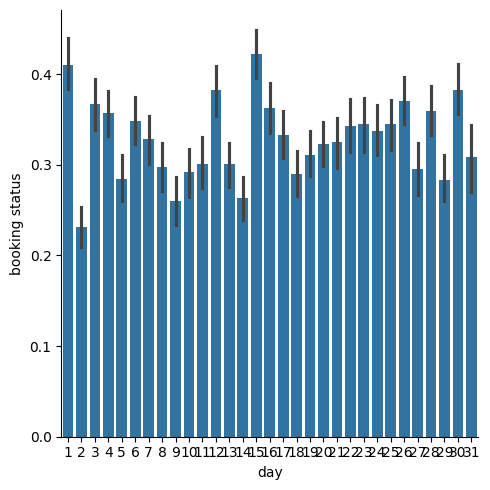

In [11]:
plt.figure(figsize=(50, 50))
sns.catplot(x="day", y = "booking status", data=pdf, kind="bar")

# it looks like there is a difference in the day of the reservation as to whether it was cancelled or not

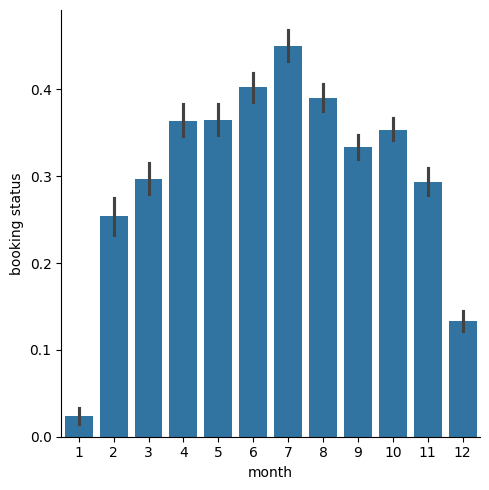

In [12]:
sns.catplot(x="month", y = "booking status", data=pdf, kind="bar")
# it looks like there are more cancellations during the summer months, especialy for July reservations. Maybe this is correlated to how many bookings have been
# made during the summer months. In January bookings, the cancellations are really low. 

In [13]:
# First create a dataframe with number of cancellations per month
pdf_monthly = pdf.groupby(["month", "booking status"]).size().reset_index(name="count")

# Let's check for statistical significance for stationarity using the KPSS test
def kpss_test(pdf: pd.DataFrame, col:str) -> None:
    result = kpss(pdf[col])
    print(f'KPSS Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[3].items():
        print(f'\t{key}: {value}')

    if result[1] > 0.05:
        print("The series is stationary")
    else:
        print("The series is not stationary")

kpss_test(pdf=pdf_monthly, col='booking status')
# As suspected the series is not stationary

KPSS Statistic: 0.49999999999999817
p-value: 0.04166666666666708
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
The series is not stationary


For now this is enough, we're going to keep the seasonal dummies month and date in the model, as they have information which will be useful for us

Let's check if there is a pattern on room type:

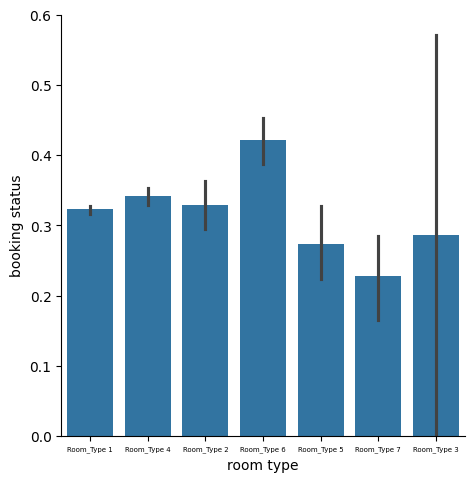

In [14]:
sns.catplot(x="room type", y = "booking status", data=pdf, kind="bar")
plt.xticks(fontsize=5);

We can see that different room types have different cancellation percentages. This might mean that the room type as a feature is very indicative of cancellation.
Particularly room type 6 is prone to cancellation, whereas room type 7 is more often not cancelled.

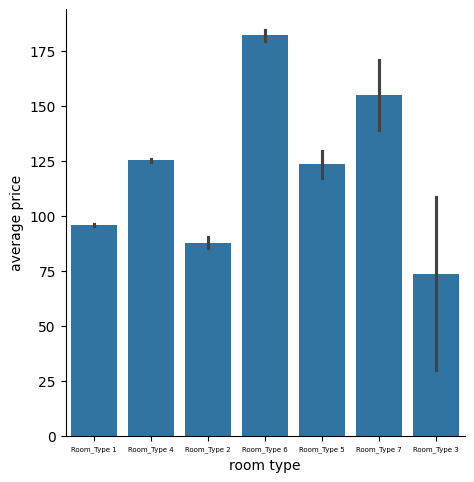

In [15]:
# Let's look into average price per room type and see if there is a difference in cancellations

sns.catplot(x="room type", y = "average price", data=pdf, kind="bar")
plt.xticks(fontsize=5);

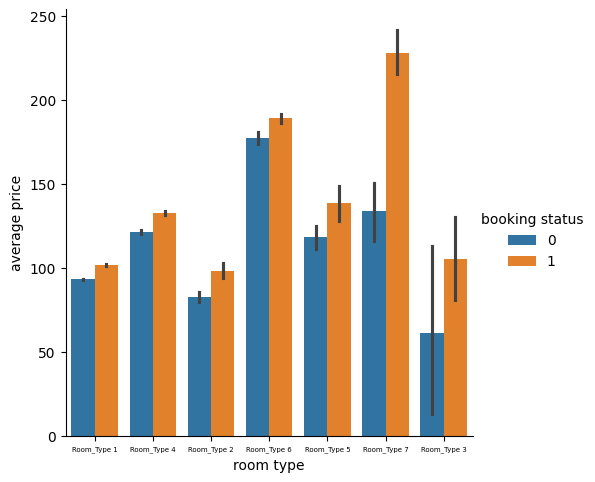

In [16]:
sns.catplot(x="room type", y = "average price", data=pdf, kind="bar", hue="booking status")
plt.xticks(fontsize=5);
# this is interesting, the booking status differs per room type and price. Let's keep both features in the model

In [17]:
print(pdf.groupby([ "booking status"]).size().reset_index(name="count"))

   booking status  count
0               0  24366
1               1  11882


In [18]:
print(pdf.groupby([ "room type","type of meal" ]).size().reset_index(name="count"))
# I think type of meal doesn't hold any valuable information, and it's quite skewed

      room type  type of meal  count
0   Room_Type 1   Meal Plan 1  20140
1   Room_Type 1   Meal Plan 2   2933
2   Room_Type 1   Meal Plan 3      1
3   Room_Type 1  Not Selected   5039
4   Room_Type 2   Meal Plan 1    653
5   Room_Type 2   Meal Plan 2     16
6   Room_Type 2  Not Selected     23
7   Room_Type 3   Meal Plan 1      5
8   Room_Type 3  Not Selected      2
9   Room_Type 4   Meal Plan 1   5743
10  Room_Type 4   Meal Plan 2    272
11  Room_Type 4   Meal Plan 3      1
12  Room_Type 4  Not Selected     35
13  Room_Type 5   Meal Plan 1    240
14  Room_Type 5   Meal Plan 2     14
15  Room_Type 5  Not Selected      9
16  Room_Type 6   Meal Plan 1    876
17  Room_Type 6   Meal Plan 2     66
18  Room_Type 6  Not Selected     22
19  Room_Type 7   Meal Plan 1    152
20  Room_Type 7   Meal Plan 2      2
21  Room_Type 7   Meal Plan 3      3
22  Room_Type 7  Not Selected      1


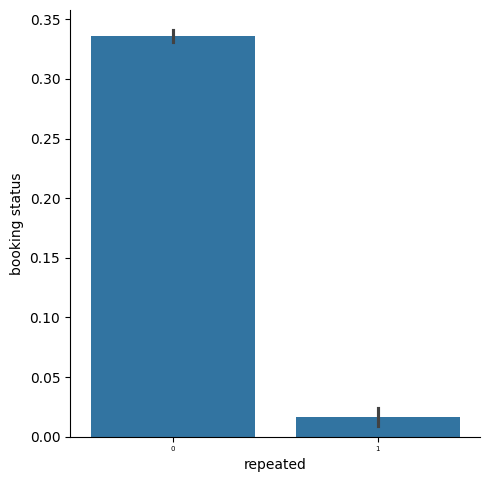

In [19]:
# let's check is repeated column if it has a pattern related to cancellations

sns.catplot(x="repeated", y = "booking status", data=pdf, kind="bar")
plt.xticks(fontsize=5);

# we mostly have new customers in the data, so this feature is not very informative

Let's look at the variability in the numerical columns:

<Axes: xlabel='average price', ylabel='Count'>

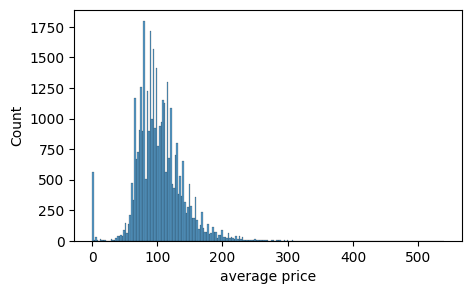

In [20]:
# Histograms
plt.figure(figsize=(5, 3))
sns.histplot(pdf['average price'])

<Axes: xlabel='lead time', ylabel='Count'>

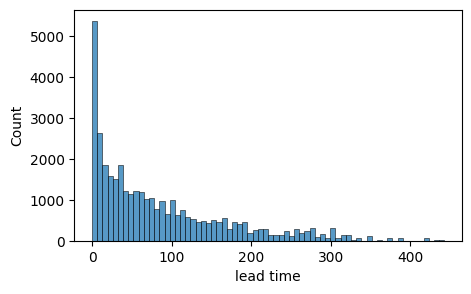

In [21]:
plt.figure(figsize=(5, 3))
sns.histplot(pdf['lead time']) # Number of days between the booking date and the arrival date
# let's keep this feature in the model. it's an interesting distribution

### Correlation matrix between numerical variables

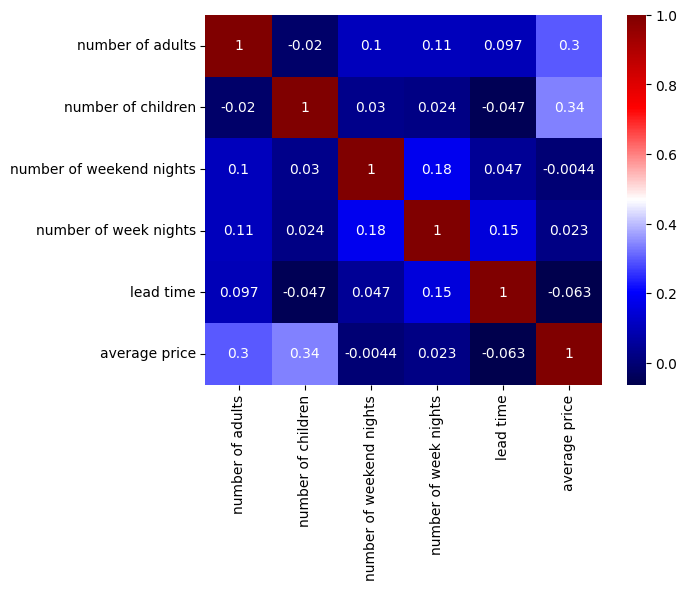

In [22]:
pdf_corr = pdf[["number of adults", "number of children", "number of weekend nights", "number of week nights", "lead time", "average price"]]

corr_matrix = pdf_corr.corr()
# print(corr_matrix)
sns.heatmap(corr_matrix, annot=True, cmap="seismic")
plt.show()

# It shows that there is not high correlation between the numerical variables (reds: high, white: moderate correlation, blues: low)
# as long as we're not >0.5 or lower than -0.5 we're good

### Correlation matrix between categorical variables

In [48]:
from scipy.stats import chi2_contingency

chi_data = pdf[["car parking space", "room type"]]

chi2_stat, p_value, dof, expected = chi2_contingency(pd.crosstab(chi_data['type of meal'], chi_data['room type']))

alpha = 0.05

if p_value <= alpha:
    print(f'p-values is {p_value:.3f}. Variables are not independent (reject H0)')
    print(f'chi2_stat is {chi2_stat:.1f}')
else:
    print(f'p-values is {p_value:.3f}. Variables are independent (fail to reject H0)')

#  less statistical power

p-values is 0.000. Variables are not independent (reject H0)
chi2_stat is 2350.9


### Check VIF

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = pdf[["number of adults", "number of children", "number of weekend nights", "number of week nights", "lead time", "average price"]]

# calculate vif score
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

if vif["VIF"].max() > 10:
    print("There are variables with high multicollinearity")
else:
    print("There are no variables with high multicollinearity")

# I will keep number of adults outside the model, as there is high multicollinearity with another variable

                  variables        VIF
0          number of adults  11.016699
1        number of children   1.218759
2  number of weekend nights   1.929105
3     number of week nights   3.461453
4                 lead time   2.016944
5             average price   9.624998
There are variables with high multicollinearity


In [ ]:
pdf.to_csv("data/processed_bookings.csv", sep=";")